In [1]:
# importing data manipulation libraries
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import ML tools 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# configure notebook for inline plotting
%matplotlib inline

# config pandas to display more than 20 columns
pd.set_option('display.max_columns',250)

# set grid style 
sns.set_style('darkgrid')

In [2]:
# load data from file
data = pd.read_csv('./data/match_data_avg_stats.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [3]:
# drop matches with "incomplete" or "suspended" status
data = data[data['status'] == 'complete']

In [4]:
# check shape of data
data.shape

(6278, 49)

In [5]:
# Get the shape (number of rows and columns) where the 'team_a_xg_prematch' column is equal to 0
data[data['team_a_xg_prematch']==0].shape

(3609, 49)

In [6]:
# Get the shape (number of rows and columns) where the 'team_b_xg_prematch' column is equal to 0
data[data['team_b_xg_prematch']==0].shape

(3609, 49)

In [7]:
# Get the shape (number of rows and columns) where the 'total_xg_prematch' column is equal to 0
data[data['total_xg_prematch']==0].shape

(3603, 49)

In [8]:
# # check entries with values == 0
# columns_to_drop = ['team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [9]:
# # drop columns with missing values
# data.drop(columns=columns_to_drop, inplace=True)

In [10]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667


In [11]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']
    
    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [12]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

In [13]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 50)

In [14]:
data[data['odds_ft_1']==0].shape

(1915, 50)

In [15]:
# check shape of dataframe 
data.shape

(6278, 50)

In [16]:
# drop entries where odds is zero
cleaned_data = data.drop(index=data[data['odds_ft_1']==0].index)

In [17]:
# check size of new dataframe
cleaned_data.shape

(4363, 50)

In [18]:
# inspect column to check that entries with zeros have been dropped
cleaned_data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [19]:
# get dataframe info
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 6279
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4363 non-null   int64  
 1   homeID                 4363 non-null   int64  
 2   awayID                 4363 non-null   int64  
 3   home_name              4363 non-null   object 
 4   away_name              4363 non-null   object 
 5   date                   4363 non-null   object 
 6   season                 4363 non-null   object 
 7   status                 4363 non-null   object 
 8   homeGoalCount          4363 non-null   int64  
 9   awayGoalCount          4363 non-null   int64  
 10  totalGoalCount         4363 non-null   int64  
 11  team_a_cards_num       4363 non-null   int64  
 12  team_b_cards_num       4363 non-null   int64  
 13  odds_ft_1              4363 non-null   float64
 14  odds_ft_x              4363 non-null   float64
 15  odds

In [20]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'home_name', 'away_name', 'date', 'season','status']
#                  , 'homeGoalCount', 'awayGoalCount', 'totalGoalCount']

# Drop the specified columns from the DataFrame
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

In [21]:
# inspect cleaned dataset to confirm columns were dropped successfully
cleaned_data.head()

,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,1.053772,1.976917,1.107030,1.128482,1.053772,1.773939,1.056286,1.026993,3.933333,6.333333,7.200000,8.533333,0.866667,1.733333,1.2,0.666667,1.386147,1.923433,-0.002514,0.746946,280.333333,238.133333,20.133333,25.733333,185.066667,168.266667,20.933333,22.666667,1
1,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,0.982456,1.125890,1.571102,1.606961,0.931711,1.125890,1.418868,1.606961,5.733333,5.733333,6.666667,7.400000,0.466667,1.333333,1.0,1.400000,0.958993,1.077167,-0.487157,-0.481071,274.466667,217.933333,23.600000,28.000000,179.533333,256.466667,20.266667,26.333333,2
2,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,1.111550,1.211611,1.430625,1.335043,1.060806,1.058202,1.278391,1.284298,3.733333,4.466667,8.733333,7.800000,1.000000,0.800000,1.6,1.200000,1.137407,1.299807,-0.217585,-0.226096,208.266667,260.933333,23.866667,24.466667,182.666667,137.866667,24.866667,21.866667,2
3,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,1.469059,1.948587,1.613283,1.014782,1.215339,1.847100,1.511794,0.964038,6.466667,7.333333,9.666667,4.733333,1.266667,1.866667,1.4,1.066667,1.350113,2.020447,-0.296455,0.883062,208.533333,169.133333,21.800000,26.600000,250.666667,270.600000,24.800000,24.266667,0
4,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,NaN,0.959606,NaN,1.577794,NaN,0.908862,NaN,1.425562,NaN,5.733333,NaN,6.266667,NaN,1.133333,NaN,2.000000,NaN,1.061133,NaN,-0.516701,NaN,221.800000,NaN,22.866667,NaN,241.000000,NaN,25.066667,0


In [22]:
# check for null values
cleaned_data.isnull().sum()

homeGoalCount              0
awayGoalCount              0
totalGoalCount             0
team_a_cards_num           0
team_b_cards_num           0
odds_ft_1                  0
odds_ft_x                  0
odds_ft_2                  0
home_ppg                   0
away_ppg                   0
team_a_xg_prematch         0
team_b_xg_prematch         0
total_xg_prematch          0
xG_home                  659
xG_away                  774
xGA_home                 659
xGA_away                 774
npxG_home                659
npxG_away                774
npxGA_home               659
npxGA_away               774
deep_home                659
deep_away                774
deep_allowed_home        659
deep_allowed_away        774
scored_home              659
scored_away              774
missed_home              659
missed_away              774
xpts_home                659
xpts_away                774
npxGD_home               659
npxGD_away               774
ppda.att_home            659
ppda.att_away 

In [23]:
# drop null values
cleaned_data.dropna(inplace=True)

In [24]:
# check for null values
cleaned_data.isnull().sum()

homeGoalCount            0
awayGoalCount            0
totalGoalCount           0
team_a_cards_num         0
team_b_cards_num         0
odds_ft_1                0
odds_ft_x                0
odds_ft_2                0
home_ppg                 0
away_ppg                 0
team_a_xg_prematch       0
team_b_xg_prematch       0
total_xg_prematch        0
xG_home                  0
xG_away                  0
xGA_home                 0
xGA_away                 0
npxG_home                0
npxG_away                0
npxGA_home               0
npxGA_away               0
deep_home                0
deep_away                0
deep_allowed_home        0
deep_allowed_away        0
scored_home              0
scored_away              0
missed_home              0
missed_away              0
xpts_home                0
xpts_away                0
npxGD_home               0
npxGD_away               0
ppda.att_home            0
ppda.att_away            0
ppda.def_home            0
ppda.def_away            0
p

In [25]:
# check for null values
cleaned_data.shape

(3026, 42)

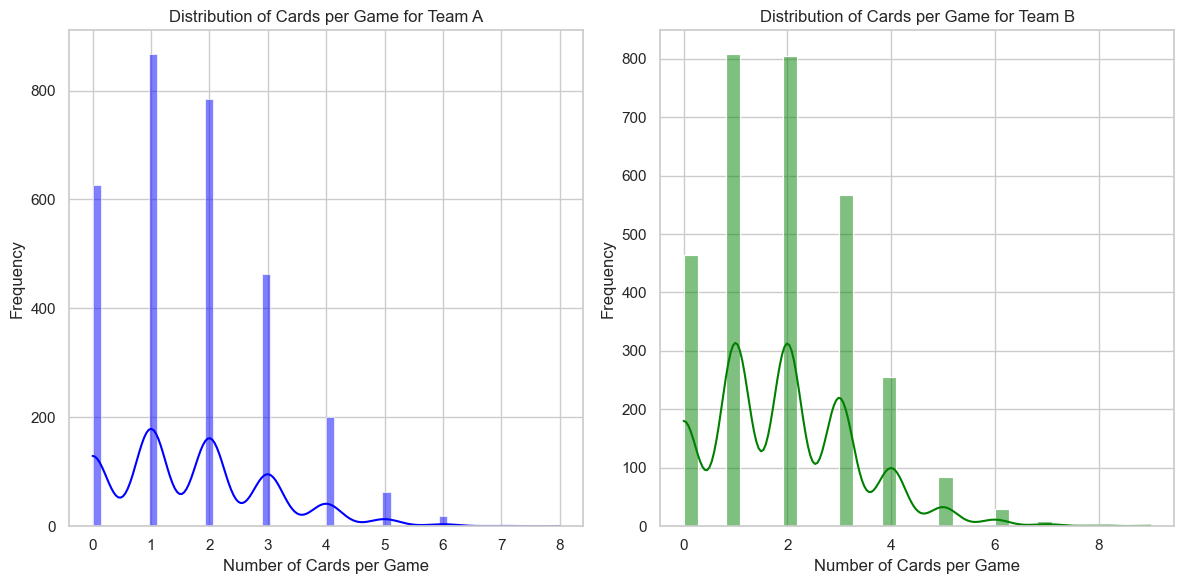

In [26]:
# Calculate the average number of cards per game for each team
# This calculation assumes each row in cleaned_data is a single game
cleaned_data['team_a_cards_per_game'] = cleaned_data['team_a_cards_num']
cleaned_data['team_b_cards_per_game'] = cleaned_data['team_b_cards_num']

# Setting the style
sns.set(style="whitegrid")

# Creating a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the distribution of average cards per game for Team A
sns.histplot(cleaned_data['team_a_cards_per_game'], ax=axes[0], kde=True, color='blue')
axes[0].set_title('Distribution of Cards per Game for Team A')
axes[0].set_xlabel('Number of Cards per Game')
axes[0].set_ylabel('Frequency')

# Plotting the distribution of average cards per game for Team B
sns.histplot(cleaned_data['team_b_cards_per_game'], ax=axes[1], kde=True, color='green')
axes[1].set_title('Distribution of Cards per Game for Team B')
axes[1].set_xlabel('Number of Cards per Game')
axes[1].set_ylabel('Frequency')

# Displaying the plot
plt.tight_layout()
plt.show()


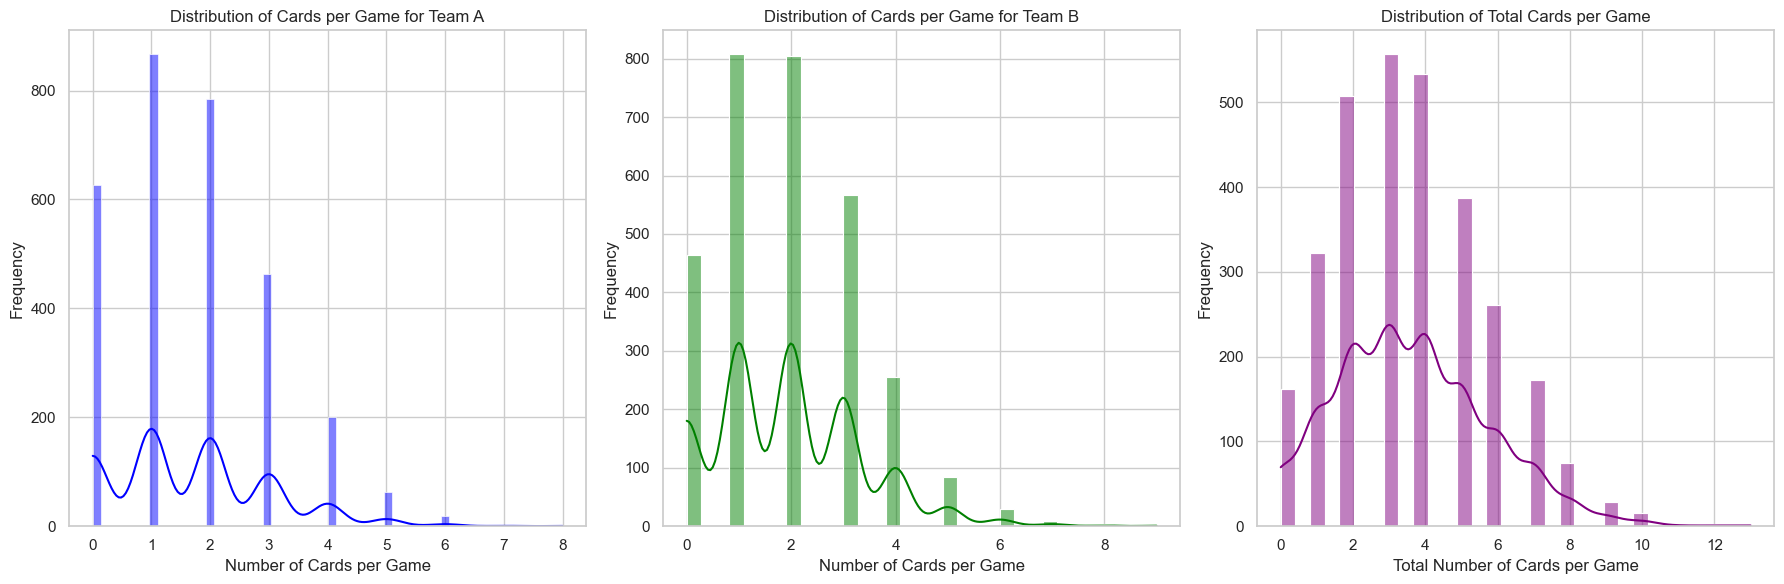

In [27]:
# Calculate the average number of cards per game for each team
# This calculation assumes each row in cleaned_data is a single game
cleaned_data['team_a_cards_per_game'] = cleaned_data['team_a_cards_num']
cleaned_data['team_b_cards_per_game'] = cleaned_data['team_b_cards_num']
cleaned_data['total_cards_per_game'] = cleaned_data['team_a_cards_per_game'] + cleaned_data['team_b_cards_per_game']

# Setting the style
sns.set(style="whitegrid")

# Creating a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the distribution of average cards per game for Team A
sns.histplot(cleaned_data['team_a_cards_per_game'], ax=axes[0], kde=True, color='blue')
axes[0].set_title('Distribution of Cards per Game for Team A')
axes[0].set_xlabel('Number of Cards per Game')
axes[0].set_ylabel('Frequency')

# Plotting the distribution of average cards per game for Team B
sns.histplot(cleaned_data['team_b_cards_per_game'], ax=axes[1], kde=True, color='green')
axes[1].set_title('Distribution of Cards per Game for Team B')
axes[1].set_xlabel('Number of Cards per Game')
axes[1].set_ylabel('Frequency')

# Plotting the distribution of total cards per game
sns.histplot(cleaned_data['total_cards_per_game'], ax=axes[2], kde=True, color='purple')
axes[2].set_title('Distribution of Total Cards per Game')
axes[2].set_xlabel('Total Number of Cards per Game')
axes[2].set_ylabel('Frequency')

# Displaying the plot
plt.tight_layout()
plt.show()


#### Data Preprocessing

In [28]:
# Correlation analysis
correlation_matrix = cleaned_data.corr()

# Set a correlation threshold
correlation_threshold = 0.8

# Find highly correlated features
highly_correlated_features = np.where(np.abs(correlation_matrix) > correlation_threshold)

# Get unique feature pairs to avoid duplication
unique_correlations = [(correlation_matrix.columns[i], correlation_matrix.columns[j])
                       for i, j in zip(*highly_correlated_features) if i != j and i < j]

print("Highly Correlated Feature Pairs:")
for feature_pair in unique_correlations:
    print(f"{feature_pair[0]} and {feature_pair[1]} with correlation {correlation_matrix.loc[feature_pair[0], feature_pair[1]]}")

Highly Correlated Feature Pairs:
team_a_cards_num and team_a_cards_per_game with correlation 1.0
team_b_cards_num and team_b_cards_per_game with correlation 1.0
odds_ft_x and odds_ft_2 with correlation 0.8076707822890407
team_a_xg_prematch and team_b_xg_prematch with correlation 0.8548393073070563
team_a_xg_prematch and total_xg_prematch with correlation 0.9694173944275533
team_b_xg_prematch and total_xg_prematch with correlation 0.9560416481728858
xG_home and npxG_home with correlation 0.9790817005868561
xG_home and scored_home with correlation 0.8027175229118294
xG_home and xpts_home with correlation 0.9288684587286042
xG_home and npxGD_home with correlation 0.8942368659209031
xG_away and npxG_away with correlation 0.9814269810730257
xG_away and deep_away with correlation 0.8109790232254047
xG_away and scored_away with correlation 0.8450018141338475
xG_away and xpts_away with correlation 0.900890486942434
xG_away and npxGD_away with correlation 0.8906568996361799
xGA_home and npxGA_h

C:\Users\jmwan\AppData\Local\Temp\ipykernel_11504\2096409209.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  filtered_data = cleaned_data[selected_features]


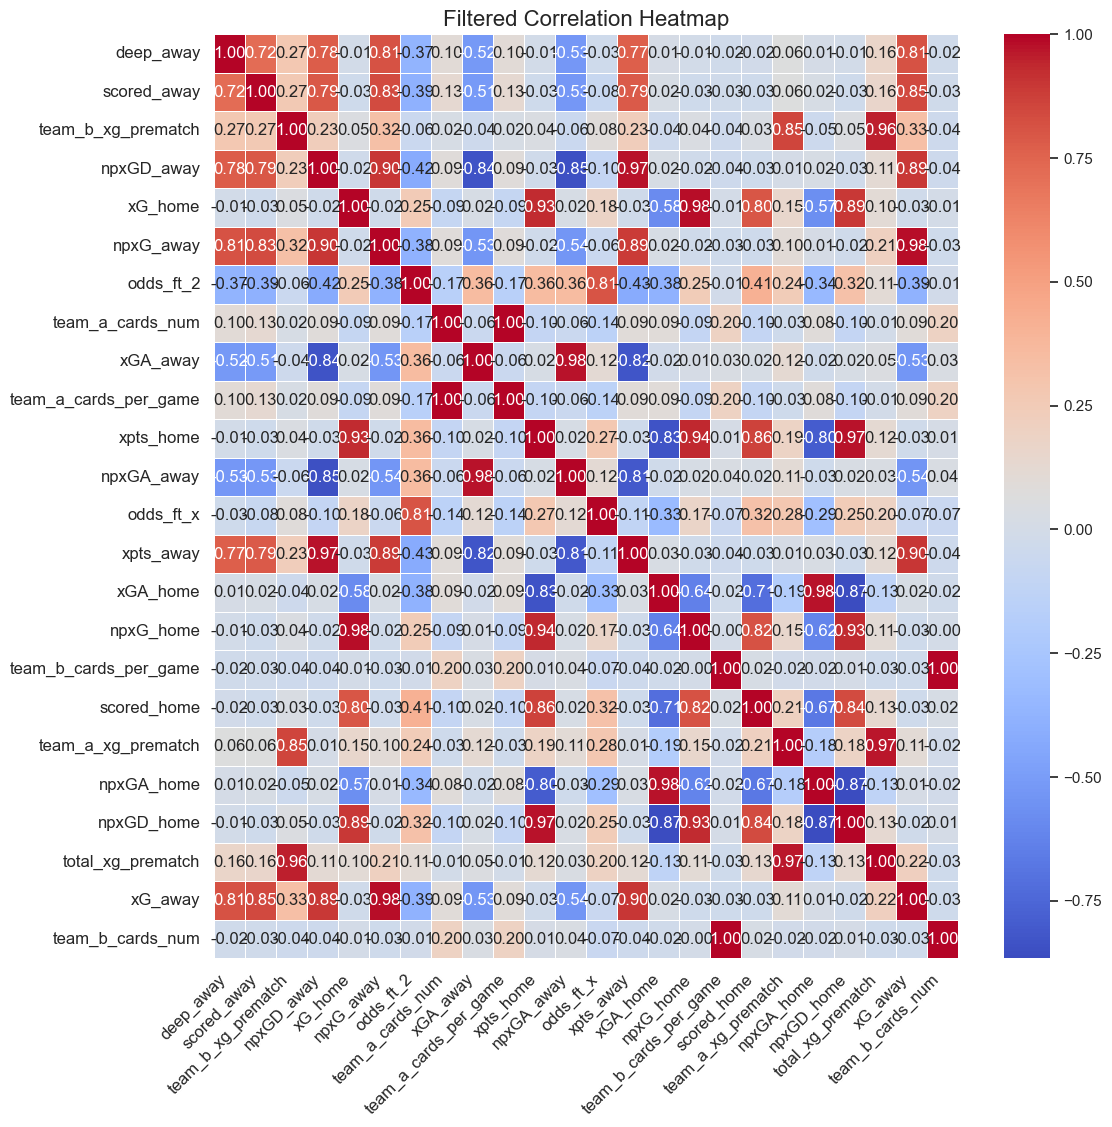

In [29]:
# create a new DataFrame with only the selected features
selected_features = set(feature for pair in unique_correlations for feature in pair)
filtered_data = cleaned_data[selected_features]

# Visualize the filtered correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(filtered_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title("Filtered Correlation Heatmap", fontsize=16)
plt.show()

In [30]:
# Aggregating card counts
cleaned_data['total_cards'] = cleaned_data['team_a_cards_num'] + cleaned_data['team_b_cards_num']

Splitting the dataset into features (X) and target variable (y)

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Selecting a subset of features that might be relevant for predicting cards
features = [
    'home_ppg', 'away_ppg', 'odds_ft_1', 'odds_ft_x', 'odds_ft_2', 
    'homeGoalCount', 'awayGoalCount', 'totalGoalCount', 
    'team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch'
]

# Preprocessing: Handling missing values by filling them with the mean
cleaned_data[features] = cleaned_data[features].fillna(cleaned_data[features].mean())

# Splitting the dataset into features (X) and target variable (y)
X = cleaned_data[features]
y = cleaned_data['total_cards']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [32]:
# Print the shape of the training feature set (X_train)
print('The shape of X_train is: ',X_train.shape)

The shape of X_train is:  (2420, 11)


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Now, X_train_scaled and X_test_scaled are the scaled versions of your training and test sets


Baseline Model

Decision Tree Regressor

Possible solutions:
Review features: 

Ensure that the features used in your model are relevant and meaningful for predicting the target variable.

Consider more advanced models: Decision trees, especially if deep, can easily overfit the training data. You might want to explore more sophisticated models or apply techniques like regularization.

Check for multicollinearity: High correlation among features can affect the performance of linear models, including R-squared.

In [34]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Create the RFE object
rfe = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Summarize selected features
selected_features = list(X_train.columns[rfe.support_])
print("Selected features:", selected_features)


Selected features: ['home_ppg', 'away_ppg', 'odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'homeGoalCount', 'totalGoalCount', 'team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [35]:
# Number of RFE selected features
rfe.n_features_


10

In [36]:
# from sklearn.decomposition import PCA

# # PCA for dimensionality reduction
# pca = PCA(n_components=0.95)  # 95% variance
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# # Number of components
# print("Number of PCA components:", pca.n_components_)


In [37]:
from sklearn.ensemble import RandomForestRegressor

# Create the RFE object and rank each feature
rfe = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Obtain the ranking for each feature
feature_ranking = rfe.ranking_

# Create a DataFrame to display feature names and their corresponding rankings
feature_ranking_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': feature_ranking
})

# Sort the DataFrame based on ranking
feature_ranking_df = feature_ranking_df.sort_values(by='Ranking')

# Display the feature rankings
print(feature_ranking_df)




               Feature  Ranking
0             home_ppg        1
1             away_ppg        1
2            odds_ft_1        1
3            odds_ft_x        1
4            odds_ft_2        1
5        homeGoalCount        1
7       totalGoalCount        1
8   team_a_xg_prematch        1
9   team_b_xg_prematch        1
10   total_xg_prematch        1
6        awayGoalCount        2


In [38]:
# Baseline Model: Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model
dt_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_regressor.predict(X_test)
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Cross-Validation for RMSE
cv_scores_rmse = cross_val_score(dt_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores_rmse)

# Cross-Validation for MAE
cv_scores_mae = cross_val_score(dt_regressor, X, y, cv=5, scoring='neg_mean_absolute_error')

# Cross-Validation for R-squared
cv_scores_r2 = cross_val_score(dt_regressor, X, y, cv=5, scoring='r2')

# Creating a dictionary for evaluation metrics
metrics_dict = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R-squared'],
    'Test Set': [mse, rmse, mae, r2],
    'Cross-Validation Mean': [np.mean(-cv_scores_rmse), np.mean(cv_rmse_scores), np.mean(-cv_scores_mae), np.mean(cv_scores_r2)]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the table
print(metrics_df)


      Metric  Test Set  Cross-Validation Mean
0        MSE  8.534653               8.974196
1       RMSE  2.921413               2.995531
2        MAE  2.273927               2.367472
3  R-squared -0.829900              -1.045897


Random Forest Regressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest model
rf_regressor = RandomForestRegressor(random_state=42)

# Cross-validation
rf_cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_regressor.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Creating a dictionary to hold the evaluation metrics
evaluation_metrics = {
    'Model': ['Random Forest'],
    'MSE': [mse_rf],
    'RMSE': [rmse_rf],
    'Mean CV Score (MSE)': [-rf_cv_scores.mean()]
}

# Converting the dictionary into a DataFrame
evaluation_table = pd.DataFrame(evaluation_metrics)

# Displaying the evaluation table
print(evaluation_table)


           Model       MSE      RMSE  Mean CV Score (MSE)
0  Random Forest  4.632366  2.152293             4.482209


Support Vector Machine (SVM)

XGBoost Regressor

In [40]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# XGBoost model
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Cross-validation
xgb_cv_scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_regressor.predict(X_test)

# Evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Creating a dictionary to hold the evaluation metrics
xgb_evaluation_metrics = {
    'Model': ['XGBoost'],
    'MSE': [mse_xgb],
    'RMSE': [rmse_xgb],
    'Mean CV Score (MSE)': [-xgb_cv_scores.mean()]
}

# Converting the dictionary into a DataFrame
xgb_evaluation_table = pd.DataFrame(xgb_evaluation_metrics)

# Displaying the evaluation table
print(xgb_evaluation_table)


     Model       MSE      RMSE  Mean CV Score (MSE)
0  XGBoost  5.474187  2.339698             5.049992


K-Nearest Neighbors (KNN)

In [41]:
from sklearn.neighbors import KNeighborsRegressor

# KNN model
knn_regressor = KNeighborsRegressor()

# Cross-validation
knn_cv_scores = cross_val_score(knn_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Train the model
knn_regressor.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_regressor.predict(X_test)

# Evaluation
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)

# Creating a dictionary to hold the evaluation metrics for KNN model
knn_evaluation_metrics = {
    'Model': ['KNN Model'],
    'MSE': [mse_knn],
    'RMSE': [rmse_knn],
    'Mean CV Score (MSE)': [-knn_cv_scores.mean()]
}

# Converting the dictionary into a DataFrame
knn_evaluation_table = pd.DataFrame(knn_evaluation_metrics)

# Displaying the evaluation table
print(knn_evaluation_table)


       Model       MSE      RMSE  Mean CV Score (MSE)
0  KNN Model  5.030363  2.242847             5.098463


Artificial Neural Network (ANN)

In [42]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# ANN model
ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='linear'))

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
ann_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict on test set
y_pred_ann = ann_model.predict(X_test).flatten()

# Evaluation
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)

print("ANN - MSE:", mse_ann, "RMSE:", rmse_ann)




Epoch 1/100

61/61 [==============================] - 1s 4ms/step - loss: 6.5539 - val_loss: 4.6700
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 4.7861 - val_loss: 3.9863
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 4.4809 - val_loss: 3.9134
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 4.3940 - val_loss: 3.9187
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 4.3873 - val_loss: 3.8948
Epoch 6/100
61/61 [==============================] - 0s 2ms/step - loss: 4.3203 - val_loss: 3.9476
Epoch 7/100
61/61 [==============================] - 0s 2ms/step - loss: 4.2804 - val_loss: 4.0160
Epoch 8/100
61/61 [==============================] - 0s 2ms/step - loss: 4.3290 - val_loss: 3.8758
Epoch 9/100
61/61 [==============================] - 0s 2ms/step - loss: 4.2895 - val_loss: 4.1767
Epoch 10/100
61/61 [==============================] - 0s 2ms/step - loss: 4.3487 - val_loss: 3.8889
Epoch 

In [43]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV

# # Support Vector Regressor
# svm_regressor = SVR()

# # Reduced hyperparameter tuning grid
# param_grid = {'C': [1, 10], 'gamma': [0.1, 1], 'kernel': ['rbf', 'poly']}

# # GridSearch with parallel execution
# grid_search = GridSearchCV(svm_regressor, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# # Fit and search for best parameters
# grid_search.fit(X_train, y_train)

# # Best estimator
# best_svm_regressor = grid_search.best_estimator_

# # Predict on test set
# y_pred_svm = best_svm_regressor.predict(X_test)

# # Evaluation
# mse_svm = mean_squared_error(y_test, y_pred_svm)
# rmse_svm = np.sqrt(mse_svm)

# print("SVM - MSE:", mse_svm, "RMSE:", rmse_svm)


In [44]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV

# # Support Vector Regressor
# svm_regressor = SVR()

# # Hyperparameter tuning
# param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'poly', 'sigmoid']}
# grid_search = GridSearchCV(svm_regressor, param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit and search for best parameters
# grid_search.fit(X_train, y_train)

# # Best estimator
# best_svm_regressor = grid_search.best_estimator_

# # Predict on test set
# y_pred_svm = best_svm_regressor.predict(X_test)

# # Evaluation
# mse_svm = mean_squared_error(y_test, y_pred_svm)
# rmse_svm = np.sqrt(mse_svm)

# print("SVM - MSE:", mse_svm, "RMSE:", rmse_svm)
